<a href="https://colab.research.google.com/github/FaiyazKhan11/ImageCaptioning/blob/master/Im_Cap_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
#importing os module
import os
#providing the path of the folder
#r = raw string literal
folder_path = (r'/content/drive/My Drive/Datasets/Image Captioning/banglalekhaimagecaptions-_2/images')
#using listdir() method to list the files of the folder
test = os.listdir(folder_path)
#taking a loop to remove all the images
#using ".png" extension to remove only png images
#using os.remove() method to remove the files
cnt = 0
prev = ""
for images in test:
    if images.endswith("npy"):
        #os.remove(os.path.join(folder_path, images))
        if len(images) > len(prev):
          print(images)
        cnt += 1
        prev = images

print(cnt)


8942.png
1001.png
1000.png
100.png
9154


In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf
#print(tensorflow.__version__)

In [4]:
import matplotlib.pyplot as plt
from keras.backend.tensorflow_backend import set_session
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 
warnings.filterwarnings("ignore")

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import json
from glob import glob
from PIL import Image
import pickle



print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

Using TensorFlow backend.


python 3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
keras version 2.3.1
tensorflow version 2.2.0


In [39]:
## The location of the BanglaLekhaImageCaptions_ photos
dir_Flickr_jpg = "/content/drive/My Drive/Datasets/Image Captioning/banglalekhaimagecaptions-_2/images"
## The location of the caption file
dir_Flickr_text = "/content/drive/My Drive/Datasets/Image Captioning/banglalekhaimagecaptions-_2/token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in BanglaLekhaImageCaptions: {}".format(len(jpgs)))

The number of jpg flies in BanglaLekhaImageCaptions: 9154


In [40]:
## read in the Flickr caption data
file = open(dir_Flickr_text,'r', encoding = 'utf-16')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    if w[0] == '\ufeff01.png':
      w[0] = '01.png'

    datatxt.append(w + [col[1]])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])

uni_filenames = np.unique(data.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(data.filename.values).values())

The number of unique file names : 9154
The distribution of the number of captions for each image:


Counter({2: 9154})

In [41]:
data.head(10)

,filename,index,caption
0,01.png,0,তিন জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর দুই...
1,01.png,1,একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে এ...
2,02.png,0,অনেক মেয়ে মানুষ বসে আছে।
3,02.png,1,একটি নীল জামা পরা মহিলা একটি নীল ল্যাপটপ এর দি...
4,03.png,0,অনেক মানুষ একসাথে বসে কাজ করছে।
5,03.png,1,২ টি ছোট ছেলে একজন শার্ট প্যান্ট দাড়িয়ে চেয়ে...
6,04.png,0,ছয় জন মানুষ দাড়িয়ে আছে।
7,04.png,1,"৬ জন মানুষ এলোমেলো দাড়িয়ে আছে, তাদের মাঝে ২ জন..."
8,05.png,0,এক জন মেয়ে মানুষ মাথায় ঘোমটা দিয়ে কাজ করছে। মা...
9,05.png,1,একটি মহিলা হালকা পানির উপরে দাড়িয়ে আছে শারি পর...


['দোকানের পাশে একজন মানুষ বসে আছে।', 'এক্যি পুরুষ সাদা শার্ট সোয়েটার প্যান্ট পরে হাতে একটি পেপার নিয়ে একটি টুলের উপরে বসে আছে তার পাশে একটি দোকান। ']
['একজন পুরুষ মানুষ মাথায় ইট নিচ্ছে।', 'একজন ছেলে মানুষ মাথায় ঝুড়ি দিয়ে খুয়া তুলছে। ']
['একজন নারী, দুইজন বালিকা ও দুইজন পুরুষ দাড়িয়ে আছে।', '৩ জন মেয়ে ও ১ জন পুরুষের হাতে মাশরুম আর পাশে একজন পুরুষ মানুষ।']
['মানুষ গুলো ব্যায়াম করছে।', 'একটি জিমে কিছু মানুষ ব্যায়াম করছে।']
['একজন নারী দাড়িয়ে আছে।', 'একটি পুড়ে যাওয়া ঘরের ভেতর একজন মহিলা।']


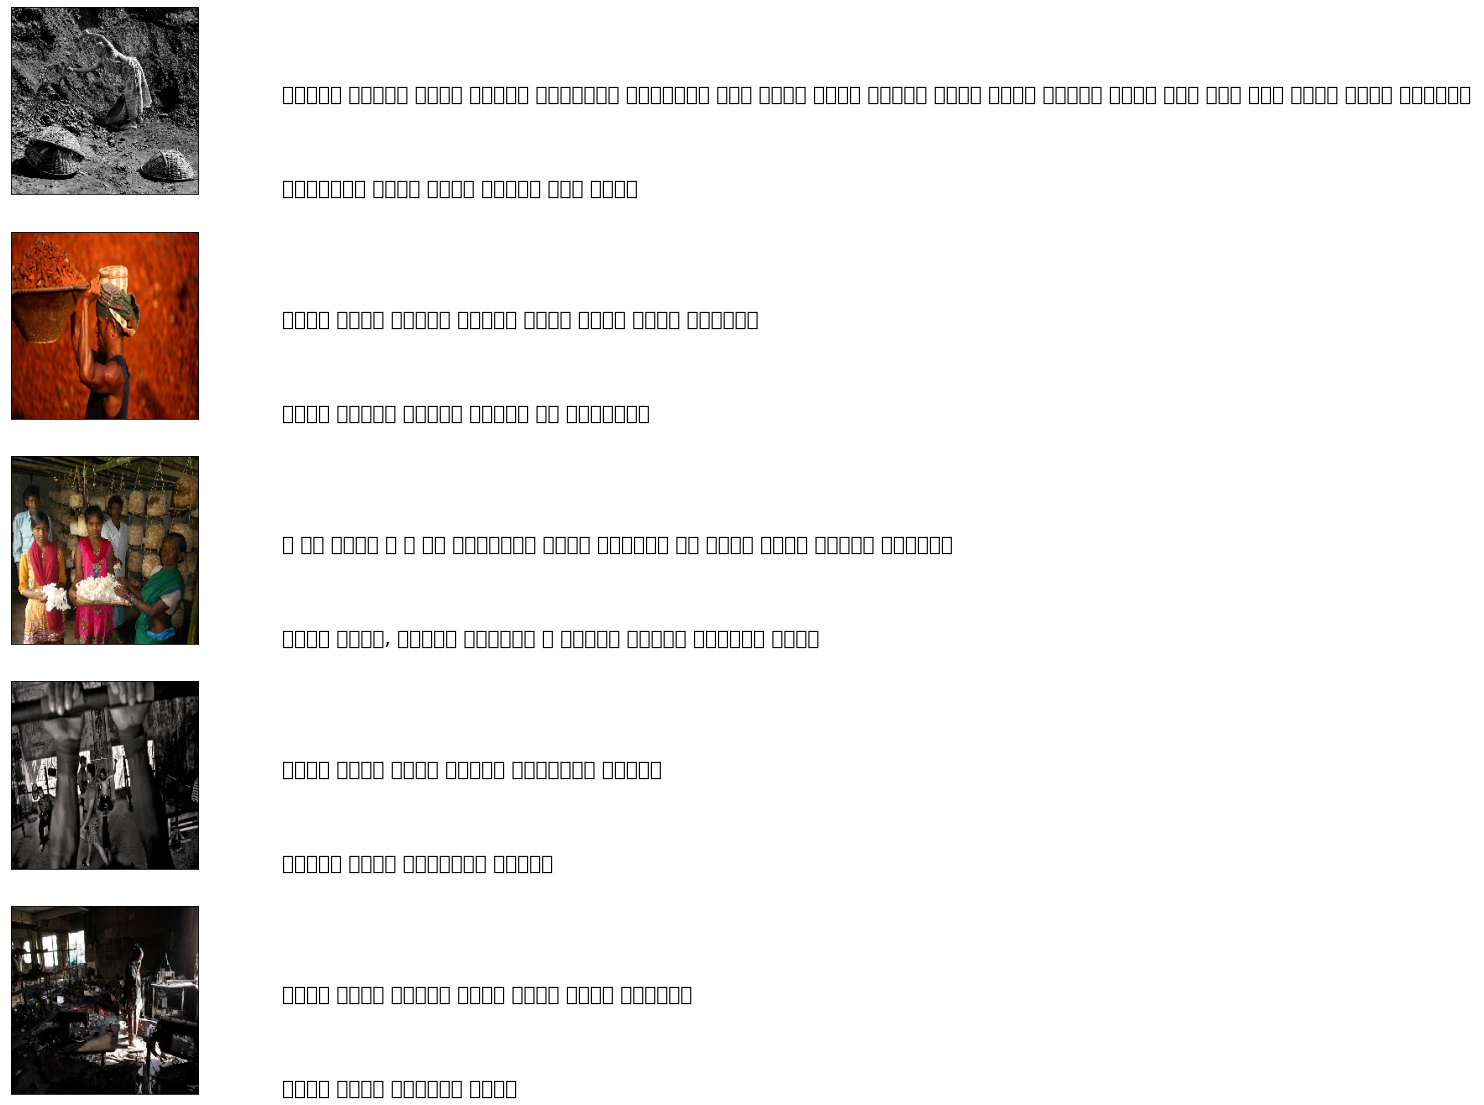

In [42]:
from keras.preprocessing.image import load_img, img_to_array

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:15]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
    print(captions)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1

In [43]:
data.shape

(18308, 3)

In [44]:
def df_word(data):
    vocabulary = []
    for txt in data.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    appen_1 = []
    appen_2 = []
    for i in ct.keys():
        appen_1.append(i)
    for j in ct.values():
        appen_2.append(j)
    data = {"word":appen_1 , "count":appen_2}
    dfword = pd.DataFrame(data)
    dfword = dfword.sort_values(by='count', ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(data)

Vocabulary Size: 5976


In [45]:
dfword.head(10)

,word,count
0,আছে।,9264
1,একজন,8775
2,একটি,6006
3,পুরুষ,4564
4,মানুষ,4091
5,দাড়িয়ে,3489
6,বসে,3379
7,ও,2350
8,দিয়ে,2223
9,জন,2201


In [46]:
dfword.tail(10)

,word,count
5966,জাত,1
5967,ধর্মের,1
5968,কুকুরগুলোকে,1
5969,রেইনকোট,1
5970,ভেঙ্গানোর,1
5971,ভেংচি,1
5972,"হেজাব,",1
5973,খুব,1
5974,নৌযান,1
5975,বেল্টের,1


In [47]:
data.caption.values

array(['তিন জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর দুই জন বসে আছে।',
       'একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে একটি বেত নিয়ে পিটানোর ভাব দেখাচ্ছে আর ছোট একটি মেয়ে পিছনে ব্যাগ নিয়ে বসে কাঁদছে। ',
       'অনেক মেয়ে মানুষ বসে আছে।', ...,
       'পানিতে একজন মানুষ ও দূরে দুইটি জাহাজ দেখা যাচ্ছে।',
       'একটা ছেলে লাফ দিচ্ছে আর আকাশে এক ঝাঁক পাখি উড়ছে।',
       'একজন পুরুষ লাফ দিয়েছে।'], dtype=object)

In [48]:
vocabulary = []
for txt in data.caption.values:
    vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))
ct = Counter(vocabulary)
ct.keys()

Vocabulary Size: 5976


dict_keys(['তিন', 'জন', 'মেয়ে', 'মানুষ', 'আছে।', 'এক', 'দাড়িয়ে', 'আছে', 'আর', 'দুই', 'বসে', 'একটি', 'হলুদ', 'জামা', 'পায়জামা', 'পরা', 'মহিলা', 'হাতে', 'বেত', 'নিয়ে', 'পিটানোর', 'ভাব', 'দেখাচ্ছে', 'ছোট', 'পিছনে', 'ব্যাগ', 'কাঁদছে।', 'অনেক', 'নীল', 'ল্যাপটপ', 'এর', 'দিকে', 'তাকিয়ে', 'এবং', 'তার', 'শারি', 'পরে', 'অনেকগুলো', 'মহিলা।', 'একসাথে', 'কাজ', 'করছে।', '২', 'টি', 'ছেলে', 'একজন', 'শার্ট', 'প্যান্ট', 'চেয়ে', 'আরেকজন', 'গার্মেন্টস', 'এ', 'করছে', 'তাদের', 'ছয়', '৬', 'এলোমেলো', 'আছে,', 'মাঝে', '৪', 'পুরুষ,', 'লুঙ্গী', 'মাথায়', 'ঘোমটা', 'দিয়ে', 'মাটিতে', 'বিভিন্ন', 'রঙের', 'মসলা', 'হালকা', 'পানির', 'উপরে', 'পরে,', 'মহিলার', 'মুখ', 'ডানদিকে', 'ঘুরানো,', 'রং', 'দেখাচ্ছে।', 'আবছা', 'অন্ধকারে', 'গুলোর', 'চেহারা', 'বোঝা', 'যাচ্ছে', 'না।', 'পুরুষ', 'কালো', 'পাঞ্জাবী', 'ঢুল', 'বাজাচ্ছে', 'চুল', 'করে', 'যার', 'কয়েকজন', ',', 'ঝাপসা', 'দেখা', 'যায়', 'ছাতা', 'ধরে', '৩', 'চাতালে', 'ধান', 'নাড়া', 'দিচ্ছে', 'সাদা', 'গেঞ্জি,', 'খালি', 'গায়ে', 'বাচ্চা', 'ছাতার', 'নিচে', 'এখানে', 'ইটের', 'টুকরা', 'ইট', '

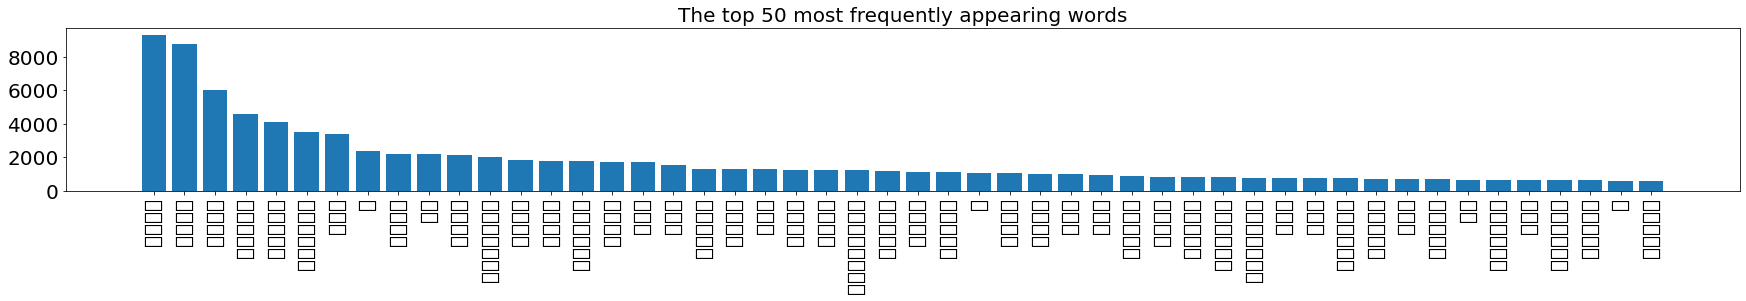

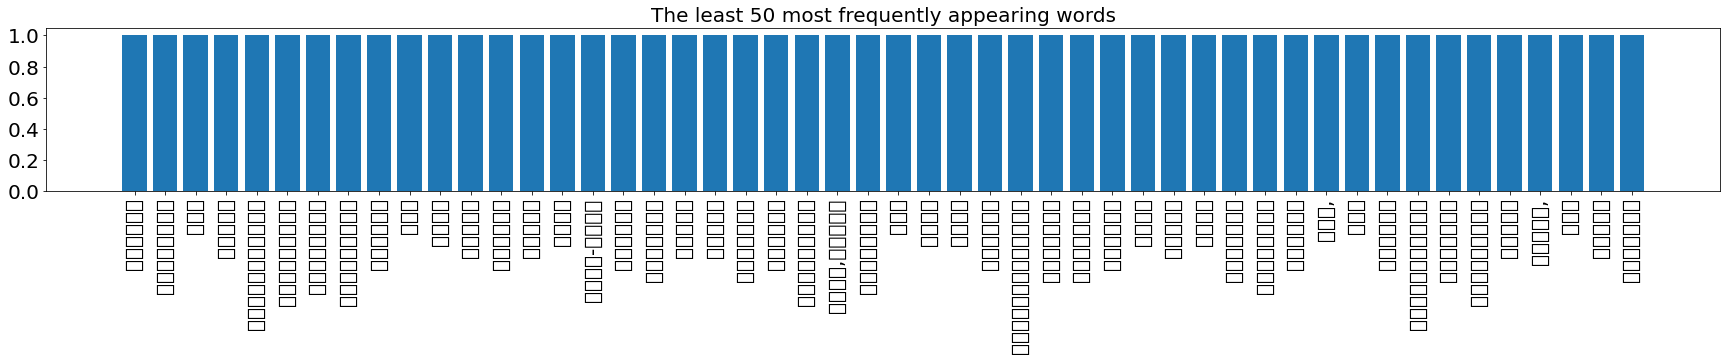

In [132]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(30,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [0]:
#make a list of images and caption
img = data["filename"].tolist()
caption = data["caption"].tolist()

In [53]:
print(f"len(img) : {len(img)}")
print(f"len(caption) : {len(caption)}")

len(img) : 18308
len(caption) : 18308


In [54]:
#Distinct images an Captions
print(f"Total Unique imgs : {len(set(img))}")
print(f"total unique captions : {len(set(caption))}")

Total Unique imgs : 9154
total unique captions : 15105


In [0]:

data.head()

,filename,index,caption
0,01.png,0,দুই জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর এক ...
1,01.png,1,একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে এ...
2,02.png,0,জলাশয় এ একজন ছেলে মানুষ ও একটি বাচ্চা মানুষ আছ...
3,02.png,1,২ জন মানুষ যার একজন পুরুষ একটি নৌকায় দাড়িয়ে চা...
4,03.png,0,অনেক মেয়ে মানুষ বসে আছে।


In [55]:
#Add start and end sequence tokens
PATH = "/content/drive/My Drive/Datasets/Image Captioning/banglalekhaimagecaptions-_2/images/"
all_captions = []

for caption  in data["caption"].astype(str):
    caption = '<start> ' + caption+ ' <end>'
    all_captions.append(caption)
all_captions[:10]

['<start> তিন জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর দুই জন বসে আছে। <end>',
 '<start> একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে একটি বেত নিয়ে পিটানোর ভাব দেখাচ্ছে আর ছোট একটি মেয়ে পিছনে ব্যাগ নিয়ে বসে কাঁদছে।  <end>',
 '<start> অনেক মেয়ে মানুষ বসে আছে। <end>',
 '<start> একটি নীল জামা পরা মহিলা একটি নীল ল্যাপটপ এর দিকে তাকিয়ে আছে এবং পিছনে  তার দিকে বসে শারি পরে তাকিয়ে আছে অনেকগুলো মহিলা।  <end>',
 '<start> অনেক মানুষ একসাথে বসে কাজ করছে। <end>',
 '<start> ২ টি  ছোট ছেলে একজন শার্ট প্যান্ট  দাড়িয়ে চেয়ে আছে আরেকজন বসে গার্মেন্টস এ কাজ করছে নীল  শার্ট পরে তাদের পিছনে অনেকগুলো মহিলা বসে দাড়িয়ে কাজ করছে।   <end>',
 '<start> ছয় জন মানুষ দাড়িয়ে আছে। <end>',
 '<start> ৬ জন মানুষ এলোমেলো দাড়িয়ে আছে, তাদের মাঝে ২ জন ছেলে ৪ জন পুরুষ,  তাদের একজন লুঙ্গী পরে দাড়িয়ে আছে।  <end>',
 '<start> এক জন মেয়ে মানুষ মাথায় ঘোমটা দিয়ে কাজ করছে। মাটিতে বিভিন্ন রঙের মসলা আছে। <end>',
 '<start> একটি মহিলা হালকা পানির উপরে দাড়িয়ে আছে শারি পরে, মহিলার মুখ ডানদিকে ঘুরানো, পানির রং হলুদ দেখাচ্ছে।  <end>']

In [56]:
all_img_name_vector = []

for annot in data["filename"]:
    full_image_path = PATH + annot

    all_img_name_vector.append(full_image_path)
all_img_name_vector[:10]

['/content/drive/My Drive/Datasets/Image Captioning/banglalekhaimagecaptions-_2/images/01.png',
 '/content/drive/My Drive/Datasets/Image Captioning/banglalekhaimagecaptions-_2/images/01.png',
 '/content/drive/My Drive/Datasets/Image Captioning/banglalekhaimagecaptions-_2/images/02.png',
 '/content/drive/My Drive/Datasets/Image Captioning/banglalekhaimagecaptions-_2/images/02.png',
 '/content/drive/My Drive/Datasets/Image Captioning/banglalekhaimagecaptions-_2/images/03.png',
 '/content/drive/My Drive/Datasets/Image Captioning/banglalekhaimagecaptions-_2/images/03.png',
 '/content/drive/My Drive/Datasets/Image Captioning/banglalekhaimagecaptions-_2/images/04.png',
 '/content/drive/My Drive/Datasets/Image Captioning/banglalekhaimagecaptions-_2/images/04.png',
 '/content/drive/My Drive/Datasets/Image Captioning/banglalekhaimagecaptions-_2/images/05.png',
 '/content/drive/My Drive/Datasets/Image Captioning/banglalekhaimagecaptions-_2/images/05.png']

In [57]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 18308
len(all_captions) : 18308


In [0]:
# Shuffle captions and image_names together
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

In [59]:
# Select the first 40000 captions from the shuffled set
num_examples = 18000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]
print(f"priviously we had {len(all_captions)} captions, and Now we have {len(train_captions)}.")

priviously we had 18308 captions, and Now we have 18000.


In [0]:
len(img_name_vector)


18000

In [0]:
dbfile1 = open('/content/drive/My Drive/Image Captioning/Attention_Keras/train_captions', 'ab')   
dbfile2 = open('/content/drive/My Drive/Image Captioning/Attention_Keras/img_name_vector', 'ab')    

pickle.dump(train_captions, dbfile1)   
pickle.dump(img_name_vector, dbfile2)                    
dbfile1.close() 
dbfile2.close()

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import InceptionV3

In [0]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [0]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [64]:

image_features_extract_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [69]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

print(f"Let's check the BatchDataset shapes--> {image_dataset}")

Let's check the BatchDataset shapes--> <BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>


In [0]:
from tqdm import tqdm

In [68]:
%%time
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

572it [49:06,  5.15s/it]

CPU times: user 4min 30s, sys: 18.1 s, total: 4min 49s
Wall time: 49min 6s


In [70]:
bf.numpy().shape

(64, 2048)

In [71]:
print(batch_features.numpy().shape)

(13, 64, 2048)


In [0]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [73]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)


tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'


# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')


print(cap_vector.shape)

(18000, 40)


In [0]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)


# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.15,
                                                                    random_state=0)

In [100]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(15300, 15300, 2700, 2700)

In [0]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [0]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [0]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [0]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [0]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [0]:
loss_plot = []

In [0]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [112]:
EPOCHS = 15

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.0918
Epoch 1 Batch 100 Loss 1.1480
Epoch 1 Batch 200 Loss 0.9301
Epoch 1 Loss 1.136420
Time taken for 1 epoch 182.2686378955841 sec

Epoch 2 Batch 0 Loss 0.8708
Epoch 2 Batch 100 Loss 0.8831
Epoch 2 Batch 200 Loss 0.8564
Epoch 2 Loss 0.875744
Time taken for 1 epoch 122.39624071121216 sec

Epoch 3 Batch 0 Loss 0.8763
Epoch 3 Batch 100 Loss 0.8554
Epoch 3 Batch 200 Loss 0.7493
Epoch 3 Loss 0.783342
Time taken for 1 epoch 136.91617035865784 sec

Epoch 4 Batch 0 Loss 0.6912
Epoch 4 Batch 100 Loss 0.7034
Epoch 4 Batch 200 Loss 0.7757
Epoch 4 Loss 0.722688
Time taken for 1 epoch 134.49395084381104 sec

Epoch 5 Batch 0 Loss 0.6881
Epoch 5 Batch 100 Loss 0.7041
Epoch 5 Batch 200 Loss 0.7226
Epoch 5 Loss 0.676140
Time taken for 1 epoch 133.05328917503357 sec

Epoch 6 Batch 0 Loss 0.6787
Epoch 6 Batch 100 Loss 0.6914
Epoch 6 Batch 200 Loss 0.5871
Epoch 6 Loss 0.633215
Time taken for 1 epoch 135.35340189933777 sec

Epoch 7 Batch 0 Loss 0.5434
Epoch 7 Batch 100 Loss 0.5493
E

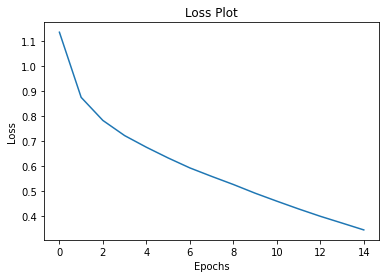

In [113]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [0]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [0]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> একজন পুরুষ ও একটি শিশু আছে। <end>
Prediction Caption: চারজন ছেলে পাহারের নিচে কিছু বাচ্চা দাড়িয়ে আছে। <end>


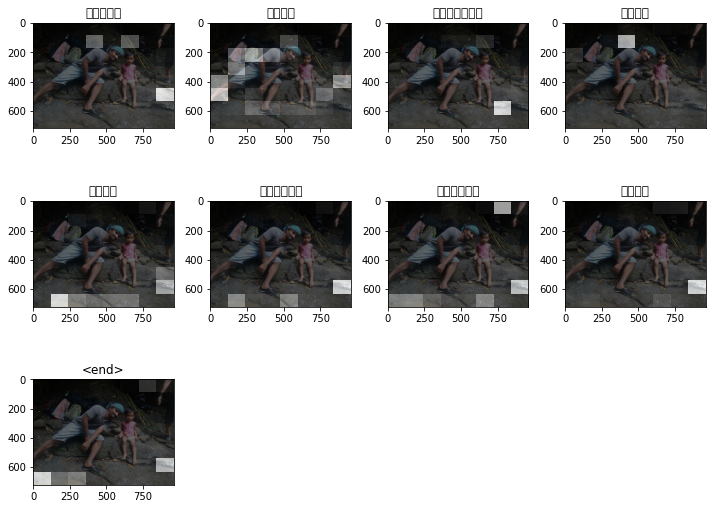

In [120]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

65536/64400 [==============================] - 0s 0us/step
Prediction Caption: দুইজন ছোট ছেলে পানিতে গোসল করছে। <end>


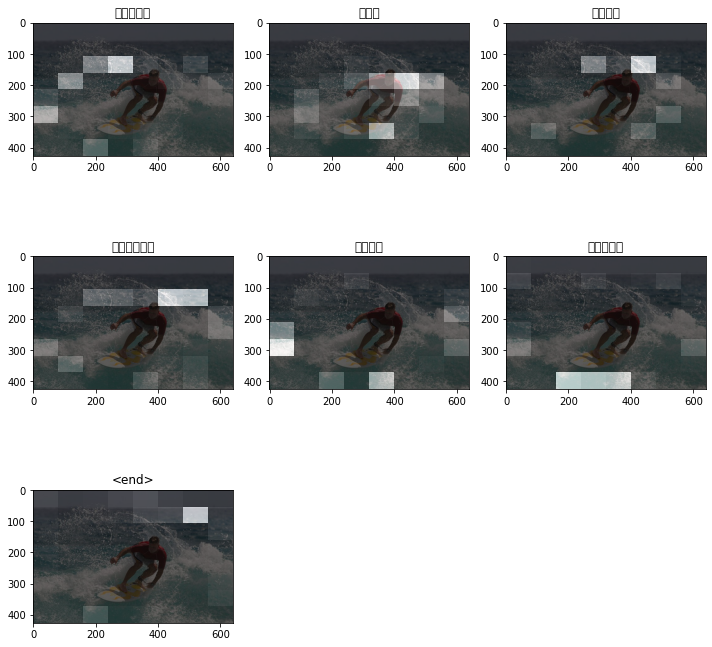

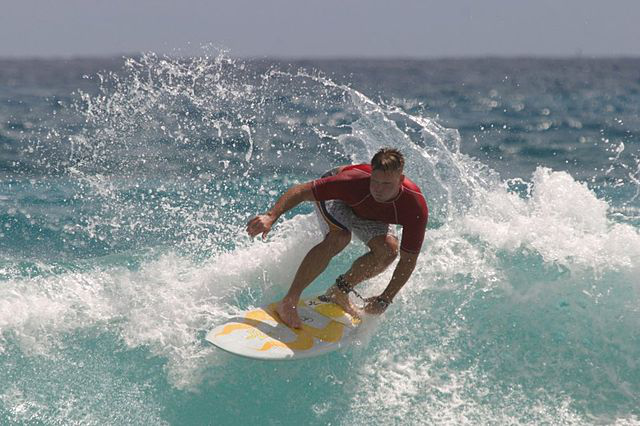

In [121]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

Real Caption: <start> একজন ছোট মেয়ে সারা <unk> রং মেখে হাতে একটি বোতল নিয়ে দাড়িয়ে হাসছে। <end>
Prediction Caption: একজন নারী মুখ দেখা যাচ্ছে। <end>


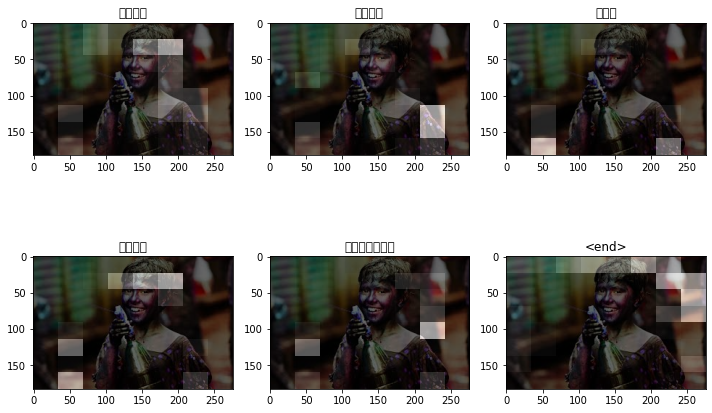

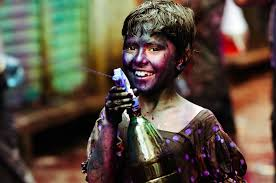

In [122]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
Image.open(img_name_val[rid])

BELU score: 0
Real Caption: একজন সবজি বিক্রেতা সবজির দোকানের সামনে দাড়িয়ে চেয়ে আছে এবং কিছু মানুষ পাসের রাস্তা দিয়ে হেটে যাচ্ছে।
Prediction Caption: কয়েকজন মানুষ আছে।


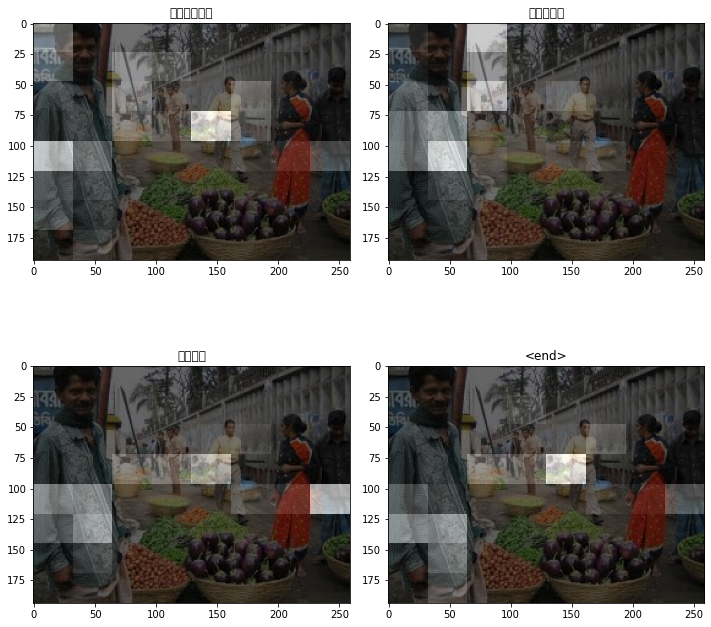

time took to Predict: 2 sec


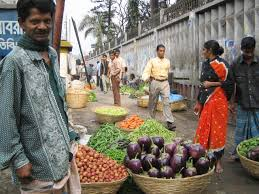

In [123]:
# captions on the validation set


# longer candidate
from nltk.translate.bleu_score import sentence_bleu

rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result         
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_val[rid])

BELU score: 0
Real Caption: রাস্তায় গাড়ি চলছে।
Prediction Caption: অনেকগুলো নৌকা আছে।


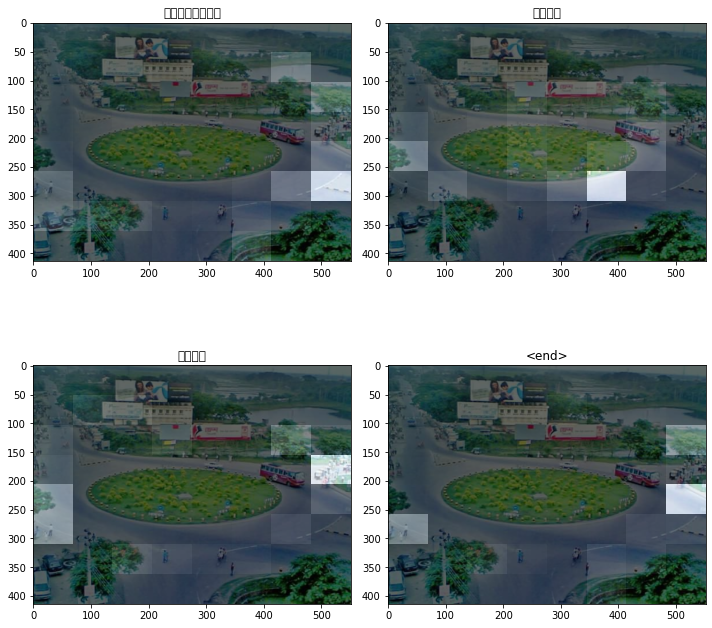

time took to Predict: 2 sec


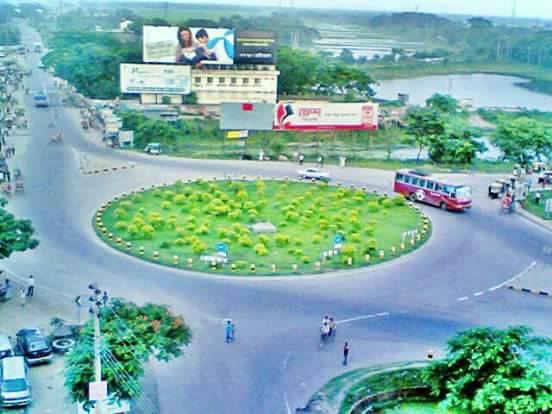

In [124]:
# captions on the validation set


# longer candidate
from nltk.translate.bleu_score import sentence_bleu

rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result         
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_val[rid])